In [125]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.transforms import v2
import os
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from kornia import enhance,filters
from torchvision import models
import torchvision
from torch import nn
from torchmetrics import PeakSignalNoiseRatio
import pytorch_lightning as pl
from torchmetrics.regression import MeanSquaredError as mse
from PIL import Image

In [2]:
torch.cuda.is_available()

True

In [3]:
RESIZE = True
IMAGE_SIZE= 224
BATCH_SIZE = 32
DEVICE = 'cuda'

In [4]:
class FiveKDataset(Dataset):
    """
    A dataset that reads Adobe5K dataset images
    output : tensor of unprocessed images
    """
    def __init__(self, image_size,mode="train", resize= True ):
        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, "..", "dataset", "FiveK")
        if mode =='train':
            self.IMGS_PATH = os.path.join(dataset_dir, "train")
        else:
            self.IMGS_PATH = os.path.join(dataset_dir, "test")
        self.resize= resize
        self.transform = transforms.Compose([
            transforms.Resize((image_size,image_size),interpolation= transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
        ])


        self.img_files = [filename for filename in os.listdir(self.IMGS_PATH+'/input/')]

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self,idx):
        source_path = self.img_files[idx]

        source = Image.open(self.IMGS_PATH+'/input/'+source_path)
        target = Image.open(self.IMGS_PATH+'/target/'+source_path)
        if self.resize:
            source = self.transform(source)
            target = self.transform(target)
        # source = self.transform(Image.open(ORIGINAL_FOLDER+source_path))

        return source, target 

In [25]:
imgs=torch.rand(32,64,64,3)
params=torch.rand(32,1)

In [140]:
import torch.nn.functional as F

def sigmoid_inverse(y):
    epsilon = 10**(-3)
    y = F.relu(y-epsilon)+epsilon
    y = 1-epsilon-F.relu((1-epsilon)-y)
    y = (1/y)-1
    output = -torch.log(y)
    return output


In [159]:
train_dataset = FiveKDataset(image_size=IMAGE_SIZE,mode='train',resize=RESIZE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True, num_workers=5 )
test_dataset = FiveKDataset(image_size=IMAGE_SIZE,mode='test',resize=RESIZE)
test_dataloader = DataLoader(test_dataset, batch_size= BATCH_SIZE , shuffle = False, num_workers=3)

class ResnetEncoder(nn.Module):
    def __init__(self,):
        super().__init__()
        self.model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        self.model = torch.nn.Sequential(*(list(self.model.children())[:-1]))#remove classifier
  
    def encode(self,images:torch.Tensor)->torch.Tensor:
        output = self.model(images)
        output = torch.flatten(output,start_dim=-3,end_dim=-1)
        return output
    
class Classifier(nn.Module):
    def __init__(self,input_shape=512,output_shape=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_shape,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,output_shape)

        )
    def forward(self,features):
        return self.net(features)

# class Net(nn.Module):
#     def __init__(self,):
#         super().__init__()
#         self.feature_extractor = ResnetEncoder()
#         self.brightness_head = nn.Sequential(
#             Classifier(output_shape=1),
#             nn.Sigmoid(),
#         )

#     def forwad(self,images):
#         features = self.feature_extractor(images)
#         brightness_factor = self.brightness_head(features)
#         output = enhance.adjust_brightness(images,brightness_factor)
#         return output

class Net(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.feature_extractor = ResnetEncoder()
        self.brightness_head = nn.Sequential(
            Classifier(output_shape=1),
            nn.Sigmoid(),
        )
        self.contrast_head= nn.Sequential(
            Classifier(output_shape=1),
            nn.Sigmoid(),
        )
        self.exposure_head = nn.Sequential(
            Classifier(output_shape=1),
            nn.Tanh(),
        )
        self.sharpness_head = nn.Sequential(
            Classifier(output_shape=1),
            nn.ReLU(),           
        )
        self.psnr = PeakSignalNoiseRatio(data_range=1.0)
        self.loss =  mse()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def forward(self, images):
        
        features = self.feature_extractor.encode(self.normalize(images))
        print(features.shape)
        brightness_factor = self.brightness_head(features)
        contrast_factor = self.contrast_head(features)
        sharpness_factor = self.sharpness_head(features)
        print('f')
        output = enhance.adjust_brightness(images,brightness_factor)
        output = enhance.adjust_contrast(output,contrast_factor)
        output = enhance.sharpness(output,sharpness_factor.squeeze(1))
        output = sigmoid_inverse(output)
        output = output+self.exposure_head(output)*5.0
        output = F.sigmoid(output)
        return output

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.loss(outputs, targets)
        psnr = self.psnr(outputs, targets)
        self.log('train_loss', loss)
        self.log('train_psnr', psnr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.loss(outputs, targets)
        psnr = self.psnr(outputs, targets)
        self.log('val_loss', loss)
        self.log('val_psnr', psnr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [160]:
model = Net()
trainer = pl.Trainer(max_epochs=10,accelerator="gpu") # Adjust the number of epochs and GPUs as needed

# Train the model
trainer.fit(model, train_dataloader, test_dataloader)

/nfshome/narjis/miniconda3/envs/photoen/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type                  | Params | Mode 
--------------------------------------------------------------------
0 | feature_extractor | ResnetEncoder         | 11.2 M | train
1 | brightness_head   | Sequential            | 74.0 K | train


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

torch.Size([32, 512])
f


RuntimeError: mat1 and mat2 shapes cannot be multiplied (21504x224 and 512x128)

In [7]:
import matplotlib.pyplot as plt
model.eval()
with torch.inference_mode():
    for i,j in train_dataloader:
        output = model(i)
        break

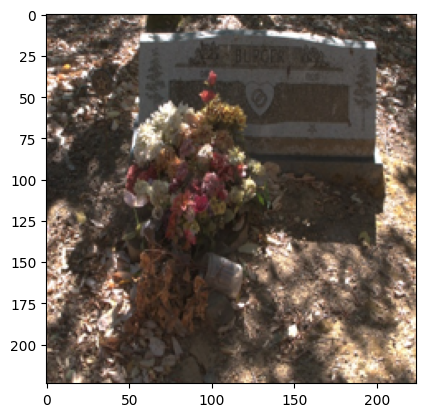

In [8]:
plt.imshow(i[0].permute(1, 2, 0))

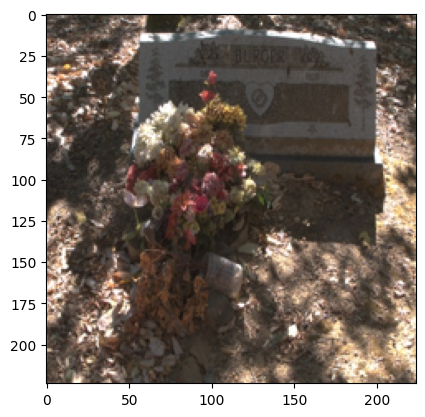

In [9]:
plt.imshow(output[0].permute(1,2,0))